In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pprint

# **Setup the dataset**

In [ ]:
# Load dataset
df = yf.download("AAPL", start="2019-01-01", end="2024-12-31")
df = df[['Close']].rename(columns={'Close': 'price'})
df.dropna(inplace=True)
df.head()

/tmp/ipython-input-3-2778383666.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,price
Ticker,AAPL
Date,
2019-01-02,37.617851
2019-01-03,33.870842
2019-01-04,35.316761
2019-01-07,35.238152
2019-01-08,35.909897


# **Time Series Analysis**

<Axes: title={'center': 'Close Price Over Time'}, xlabel='Date'>

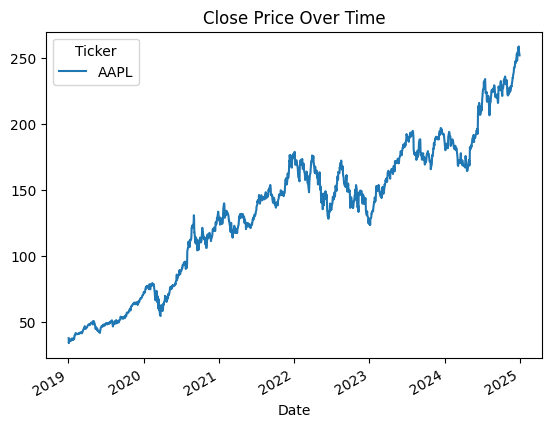

In [ ]:
# Plot Close Price
df['price'].plot(title='Close Price Over Time')

In [ ]:
# Rolling Moving Averages:
df['MA7'] = df['price'].rolling(window=7).mean()
df['MA30'] = df['price'].rolling(window=30).mean()


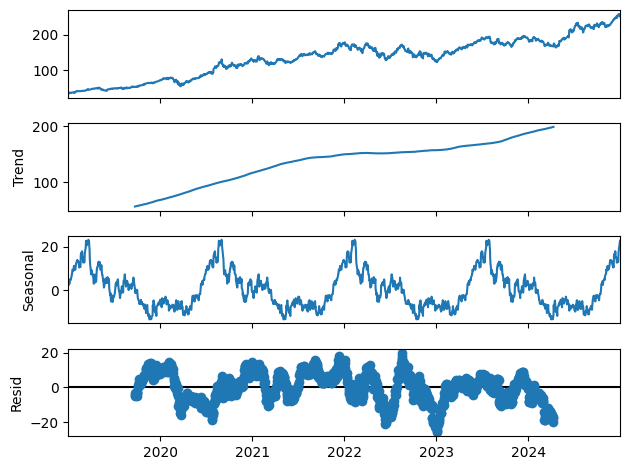

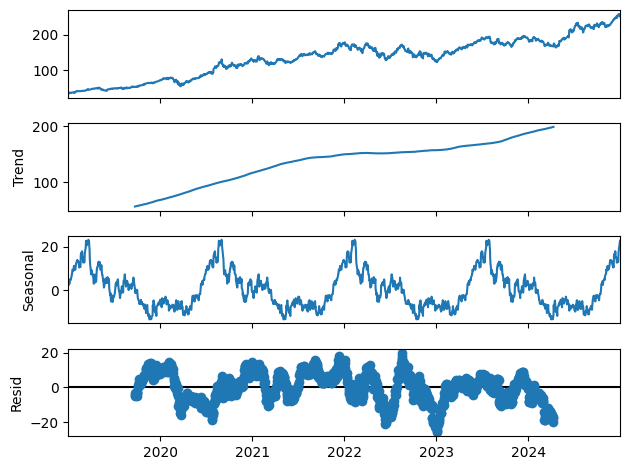

In [ ]:
# Seasonal Decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['price'], model='additive', period=365)
result.plot()

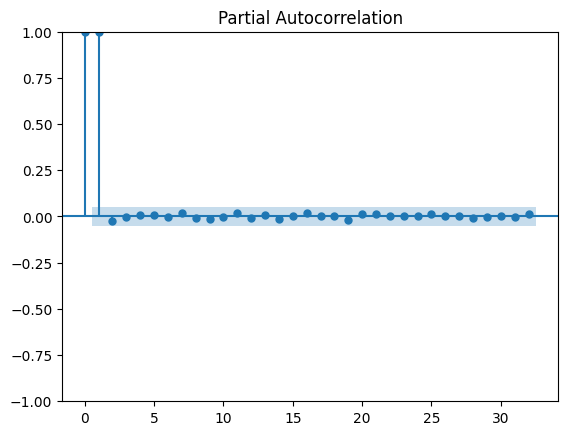

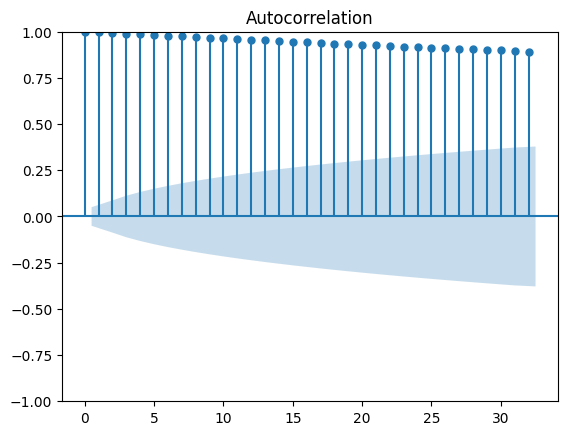

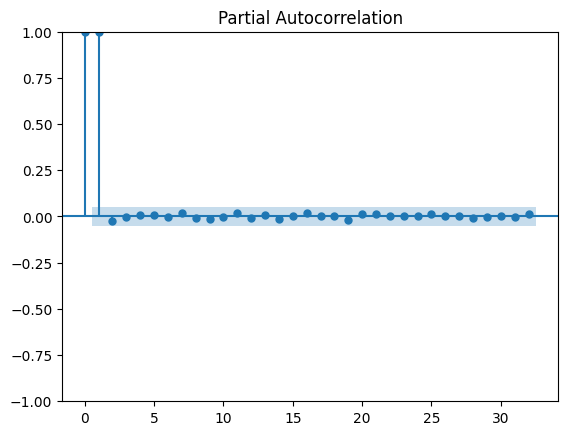

In [ ]:
# ACF/PACF:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['price'].dropna())
plot_pacf(df['price'].dropna())

In [ ]:
# Stationarity Check
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['price'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -0.47422117809074404
p-value: 0.8969496490107497


**ARIMA Model**

In [ ]:
# Split into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

Replace with Manual Grid Search (No pmdarima): becaise pmdarima create an issue

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

import itertools
p = d = q = range(0, 4)  # adjust range if needed
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(df['price'], order=order)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")


Best ARIMA order: (2, 2, 3) with AIC: 6980.16


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit best ARIMA model
model = ARIMA(train['price'], order=best_order)
model_fit = model.fit()

In [ ]:
# Forecast
n_periods = len(test)
forecast_result = model_fit.get_forecast(steps=n_periods)

# Extract forecast and confidence intervals
forecast = forecast_result.predicted_mean
confint = forecast_result.conf_int()

# Set forecast index to match test
forecast_index = test.index
forecast = pd.Series(forecast.values, index=forecast_index)


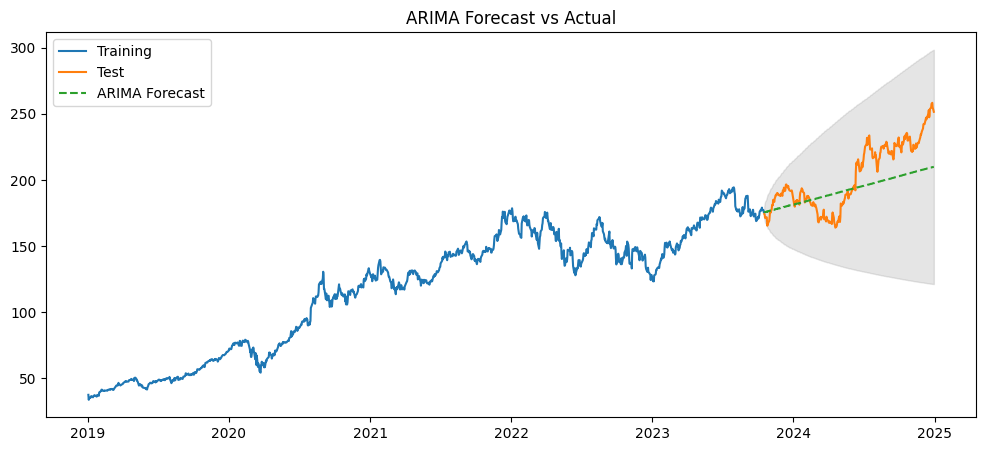

ARIMA RMSE: 19.81
ARIMA MAE: 16.64


In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['price'], label='Training')
plt.plot(test.index, test['price'], label='Test')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.fill_between(forecast.index, confint.iloc[:, 0], confint.iloc[:, 1], color='gray', alpha=0.2)
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

rmse_arima = sqrt(mean_squared_error(test['price'], forecast))
mae_arima = mean_absolute_error(test['price'], forecast)
print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAE: {mae_arima:.2f}")


# ***LSTM***

In [ ]:
# Prepare Data for LSTM

In [ ]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
# Normalize using only train
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['price']])  # force single column
test_scaled = scaler.transform(test[['price']])

In [ ]:
# Sliding window creation
def create_dataset(data, lookback=12):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 12
X_train, y_train = create_dataset(train_scaled, lookback)
X_test, y_test = create_dataset(np.vstack([train_scaled[-lookback:], test_scaled]), lookback)

In [ ]:
# Reshape to [samples, time steps, features]
X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

# **Build and Train LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
# Build model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(lookback, 1)),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 12, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,433 (212.63 KB)

 Trainable params: 54,433 (212.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(X_train, y_train,
                    epochs=400,
                    batch_size=16,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                    verbose=1)

Epoch 1/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0799 - val_loss: 9.3031e-04
Epoch 2/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 6.5495e-04 - val_loss: 9.2727e-04
Epoch 3/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.5929e-04 - val_loss: 0.0012
Epoch 4/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.7446e-04 - val_loss: 0.0017
Epoch 5/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.7257e-04 - val_loss: 6.1853e-04
Epoch 6/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6499e-04 - val_loss: 0.0020
Epoch 7/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.9981e-04 - val_loss: 0.0011
Epoch 8/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 5.2894e-04 - val_loss: 0.0012
Epoch 9/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 5.7238e-04 - val_loss: 6.2219e-04
Epoch 10/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 5.4593e-04 - val_loss: 4.8526e-04
Epoch 11/400
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.8835e-04 - val_loss:

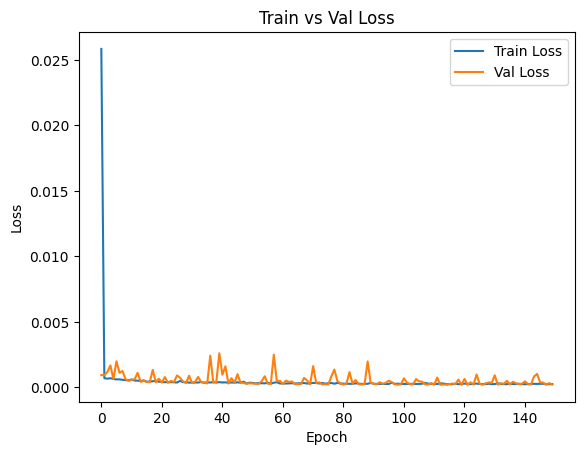

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Predict and Evaluate**

In [ ]:
# Predict
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Evaluate
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}")

LSTM RMSE: 3.97
LSTM MAE: 3.07


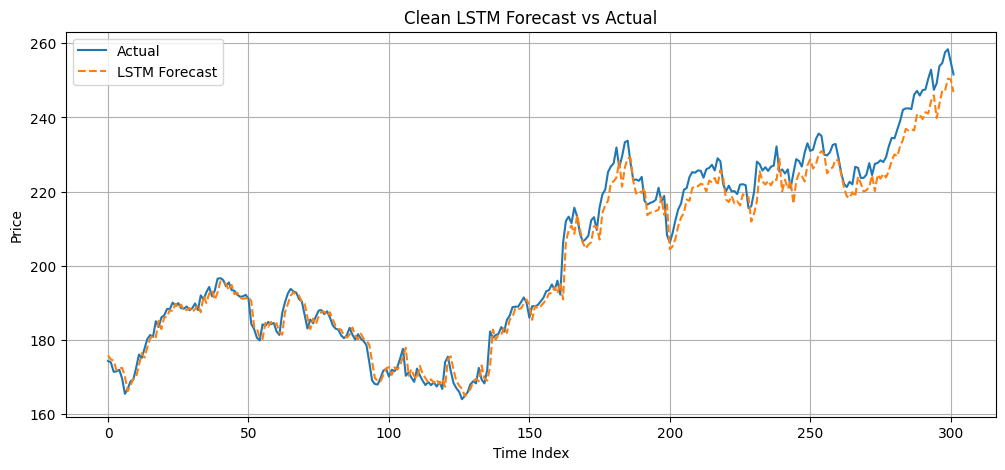

In [ ]:
# 9. Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='LSTM Forecast', linestyle='--')
plt.title("Clean LSTM Forecast vs Actual")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# **Model Performance Comparison**

In [ ]:
from IPython.display import display

results = {
    "Model": ["ARIMA","LSTM"],
    "RMSE": [rmse_arima,rmse_lstm],
    "MAE":  [mae_arima, mae_lstm]
}

results_df = pd.DataFrame(results)
results_df.set_index("Model", inplace=True)
display(results_df)

,RMSE,MAE
Model,,
ARIMA,19.809650,16.641806
LSTM,3.969422,3.073924


In [ ]:
# Reflection
print("""
Reflection:
- ARIMA is good for capturing linear trends and seasonal components.
- LSTM can model complex patterns but needs more data and tuning.
- Depending on the metrics, choose the better model based on performance and interpretability.
""")


Reflection:
- ARIMA is good for capturing linear trends and seasonal components.
- LSTM can model complex patterns but needs more data and tuning.
- Depending on the metrics, choose the better model based on performance and interpretability.

